# Lecture 19: SVM 2

### Data Science 1: CS 109A/STAT 121A/AC 209A/ E 109A <br> Instructors: Pavlos Protopapas, Kevin Rader, Rahul Dave
#### Harvard University <br> Fall 2017 <br> 

---


Import libraries

In [2]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
sns.set(style="ticks")
%matplotlib inline

In [3]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (classifier)
#      poly_flag (fits quadratic model if true, otherwise linear)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_decision_boundary(x, y, model, title, ax, bounds=(0, 1), poly_flag=False):
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='green')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='gray', alpha=0.3)
    
    # Create mesh
    interval = np.arange(bounds[0], bounds[1], 0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
        
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

Examples:

1. linearly separable vs non-separable
2. explore role of support vectors
3. explore the margin vs misclassification trade-off
4. comparison with other models

### 1. Linearly Separable vs. Nonseparable

Text(0.5,1,'Dataset 2')

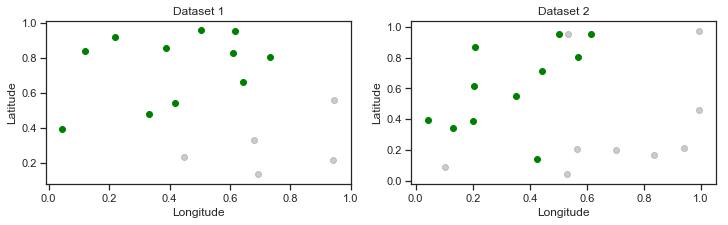

In [4]:
# Load dataset_1
data_1 = pd.read_csv('data/lecture18_data1_train.txt', delimiter=',', header=None)

# Load dataset_2
data_2 = pd.read_csv('data/lecture18_data2_train.txt', delimiter=',', header=None)

# Plot data
fig, ax = plt.subplots(1, 2, figsize = (12, 3))

#Plot dataset 1

x = data_1.values[:, [0,1]]
y = data_1.values[:, 2]

ax[0].scatter(x[y==0, 0], x[y==0, 1], c='gray', alpha=0.4)
ax[0].scatter(x[y==1, 0], x[y==1, 1], c='green')

ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_title('Dataset 1')

#Plot dataset 2

x = data_2.values[:, [0,1]]
y = data_2.values[:, 2]

ax[1].scatter(x[y==0, 0], x[y==0, 1], c='gray', alpha=0.4)
ax[1].scatter(x[y==1, 0], x[y==1, 1], c='green')

ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].set_title('Dataset 2')



It looks like the classes in Dataset 1 can be separated by a line, while the classes in Dataset 2 cannot. In Dataset 1, it's possible to find a subset of points from the two classes that are well separated, SVM chooses the subset in which the classes are maximally separated (the margin between points from different classes is maximized). In Dataset 2 it is not possible. Any decision boundary will have some errors (a mix of classes on either side).

In [5]:
data_1.head()

,0,1,2
0,0.678422,0.332760,0.0
1,0.446285,0.233264,0.0
2,0.502779,0.956748,1.0
3,0.615255,0.953660,1.0
4,0.043501,0.395151,1.0


### 2. The role of support vectors

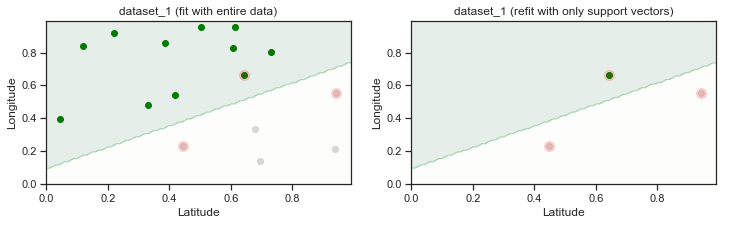

In [6]:
# Load dataset_1
x = data_1.values[:, [0,1]]
y = data_1.values[:, 2]

# Fit SVM model with C = 1000, linear kernel
model = svm.SVC(C=1000, kernel='linear')
model.fit(x, y)

# Plot decision boundary
fig, ax = plt.subplots(1, 2, figsize = (12, 3))
ax[0] = plot_decision_boundary(x, y, model, 'dataset_1 (fit with entire data)', ax[0])

# Highlight the support vectors
sv_indices = model.support_ # retrieve the support vector indices
ax[0].scatter(x[sv_indices, 0], x[sv_indices, 1], color='red', alpha=0.15, s=100) # draw circles around SVs

# Isolate only support vectors and their labels
x_svs = x[sv_indices, :] 
y_svs = y[sv_indices]
model.fit(x_svs, y_svs)

# Plot decision boundary with only support vectors
ax[1] = plot_decision_boundary(x_svs, y_svs, model, 'dataset_1 (refit with only support vectors)', ax[1])

# Highlight the support vectors
ax[1].scatter(x_svs[:, 0], x_svs[:, 1], color='red', alpha=0.15, s=100) # draw circles around SVs

plt.show()

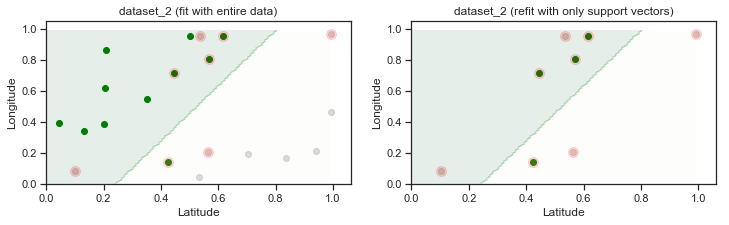

In [7]:
# Load dataset_2
x = data_2.values[:, [0,1]]
y = data_2.values[:, 2]


# Fit SVM model with C = 1000, linear kernel
model = svm.SVC(C=1000, kernel='linear')
model.fit(x, y)

# Plot decision boundary
fig, ax = plt.subplots(1, 2, figsize = (12, 3))
ax[0] = plot_decision_boundary(x, y, model, 'dataset_2 (fit with entire data)', ax[0])

# Highlight the support vectors
sv_indices = model.support_ # retrieve the support vector indices
ax[0].scatter(x[sv_indices, 0], x[sv_indices, 1], color='red', alpha=0.15, s=100) # draw circles around SVs

# Isolate only support vectors and their labels
x_svs = x[sv_indices, :] 
y_svs = y[sv_indices]
model.fit(x_svs, y_svs)

# Plot decision boundary with only support vectors
ax[1] = plot_decision_boundary(x_svs, y_svs, model, 'dataset_2 (refit with only support vectors)', ax[1])

# Highlight the support vectors
ax[1].scatter(x_svs[:, 0], x_svs[:, 1], color='red', alpha=0.15, s=100) # draw circles around SVs

plt.show()

In both cases, the decision boundary of an SVM is completely determined by a subset of data points - the support vectors.

### 3. Margin vs misclassification trade-off

In [8]:
#--------  fit_and_plot_svm_for_c
# Fit and plot SVM model for value of 'C', overlayed on a scatter plot of data 
# (fit on train set and evaluate on test set)
#
# Input: 
#      x_train (array of train predictors)
#      y_train (array of train responses)#      
#      x_test (array of test predictors)
#      y_test (array of test responses)
#      bounds (tuple of bounds for plotting)
#      C  (value for parameter C)
#      ax (axes to plot on)

def fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, C, ax, bounds=(0, 1)):
    # Fit SVM model
    model = svm.SVC(C=C, kernel='linear')
    model.fit(x_train, y_train)
    
    # Train and test error
    tr_acc = model.score(x_train, y_train)
    ts_acc = model.score(x_test, y_test)

    # Plot decision boundary
    plot_decision_boundary(x_train, y_train, model, \
                           'C = ' + str(C)\
                           + ', train acc = ' + str(tr_acc)\
                           + ', test acc = ' + str(ts_acc), ax, bounds)
    
    # Plot support vectors
    sv_indices = model.support_ # retrieve the support vector indices
    ax.scatter(x_train[sv_indices, 0], x_train[sv_indices, 1], color='red', alpha=0.15, s=100) # draw circles around SVs
    
    return ax

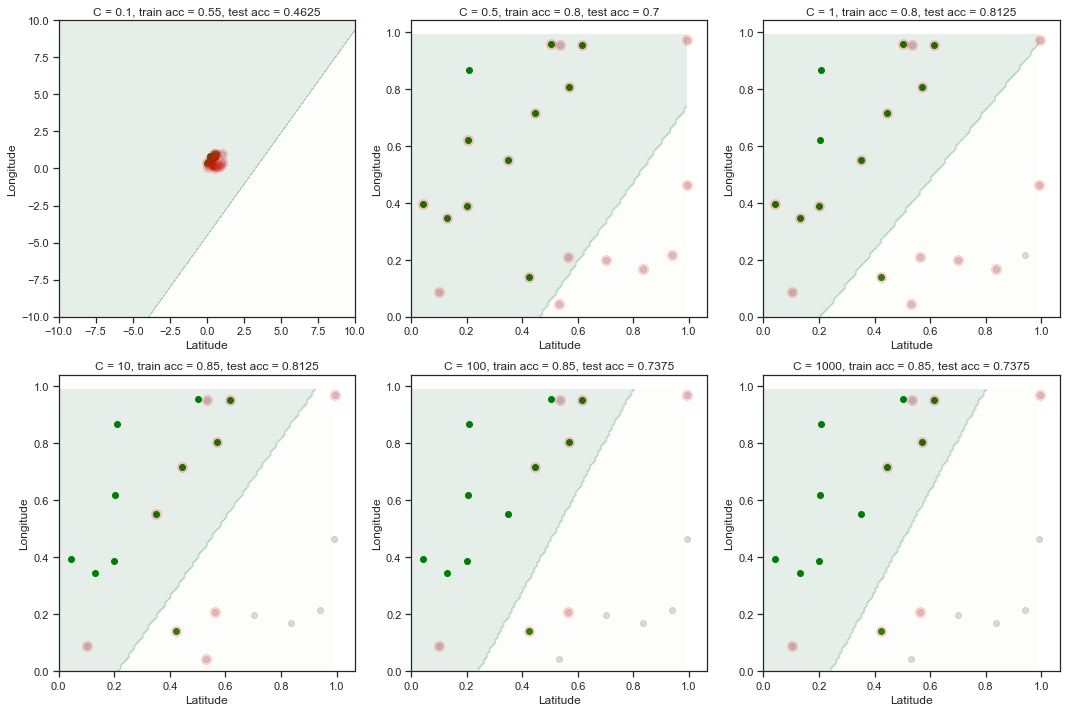

In [9]:
# Load train data
data_train = data_2.values
x_train = data_train[:, [0,1]]
y_train = data_train[:, 2]

# Load test data
data_test = pd.read_csv("data/lecture18_data2_test.txt", delimiter=',', header=None).values
x_test = data_test[:, [0,1]]
y_test = data_test[:, 2]

# Fit and plot for different 'C' values
fig, ax = plt.subplots(2, 3, figsize = (15, 10))

ax[0, 0] = fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, 0.1, ax[0, 0], (-10, 10))

ax[0, 1] = fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, 0.5, ax[0, 1])

ax[0, 2] = fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, 1, ax[0, 2])

ax[1, 0] = fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, 10, ax[1, 0])

ax[1, 1] = fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, 100, ax[1, 1])

ax[1, 2] = fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, 1000, ax[1, 2])

plt.tight_layout()

For `dataset_2`, any linear decision boundary would have some errors. In this case, SVM chooses a decision boundary by trading-off the errors for margin (i.e. balancing minimizing error with maximizing margin). The parameter $C$ controls the trade-off. 

Increasing $C$ puts more emphasis on accuracy (note that after $C=10$, train accuracy cannot be improved upon by a linear classifier and thus the decision boundary stops changing) and less emphasis on the margin of separation. As a result, the model tends to overfit the train set, and perform poorly on the test set.

### 4. Comparison with other models

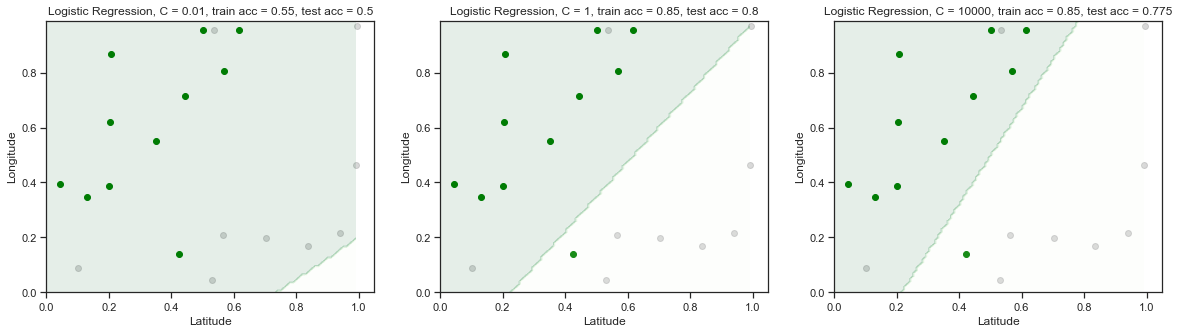

In [10]:
def fit_logistic_plot(x_train, x_test, y_train, y_test, C, ax):
    logreg = LogisticRegression(C=C)
    logreg.fit(x_train, y_train)
    test_score = logreg.score(x_test, y_test)
    train_score = logreg.score(x_train, y_train)
    ax = plot_decision_boundary(x_train, y_train, logreg, 'Logistic Regression, C = ' + str(C) + ', train acc = ' + str(train_score) + ', test acc = ' + str(test_score), ax, bounds=(0, 1), poly_flag=False)
    return ax

fig, ax = plt.subplots(1, 3, figsize = (20, 5))

ax[0] = fit_logistic_plot(x_train, x_test, y_train, y_test, 0.01, ax[0])
ax[1] = fit_logistic_plot(x_train, x_test, y_train, y_test, 1, ax[1])
ax[2] = fit_logistic_plot(x_train, x_test, y_train, y_test, 10000, ax[2])

    
plt.show()

Adjusting the margin-accuracy trade-off in SVM and the $\ell_2$ regularization parameter in logistic regression produce similar decision boundaries for Dataset 2. In this sense, considering the margin when training the model is another form of regularization. 

Other dimensions along which we can compare SVM with logistic regression:
1. training time
2. time to classify a single test data point
3. space complexity, when we store each 'model' what do we need to store?
4. ease of updating model, when the training data set changes slightly, how easy is it to retrain each model?

In [11]:
def fit_and_plot_svm_for_poly_c(x_train, y_train, x_test, y_test, C, ax, bounds=(0, 1), degree = 2):
    # Fit SVM model
    model = svm.SVC(C=C, kernel='poly', degree=degree)
    model.fit(x_train, y_train)
    
    # Train and test error
    tr_acc = model.score(x_train, y_train)
    ts_acc = model.score(x_test, y_test)

    # Plot decision boundary
    plot_decision_boundary(x_train, y_train, model, \
                           'C = ' + str(C)\
                           + ', train acc = ' + str(tr_acc)\
                           + ', test acc = ' + str(ts_acc), ax, bounds)
    
    # Plot support vectors
    sv_indices = model.support_ # retrieve the support vector indices
    ax.scatter(x_train[sv_indices, 0], x_train[sv_indices, 1], color='red', alpha=0.15, s=100) # draw circles around SVs
    
    return ax

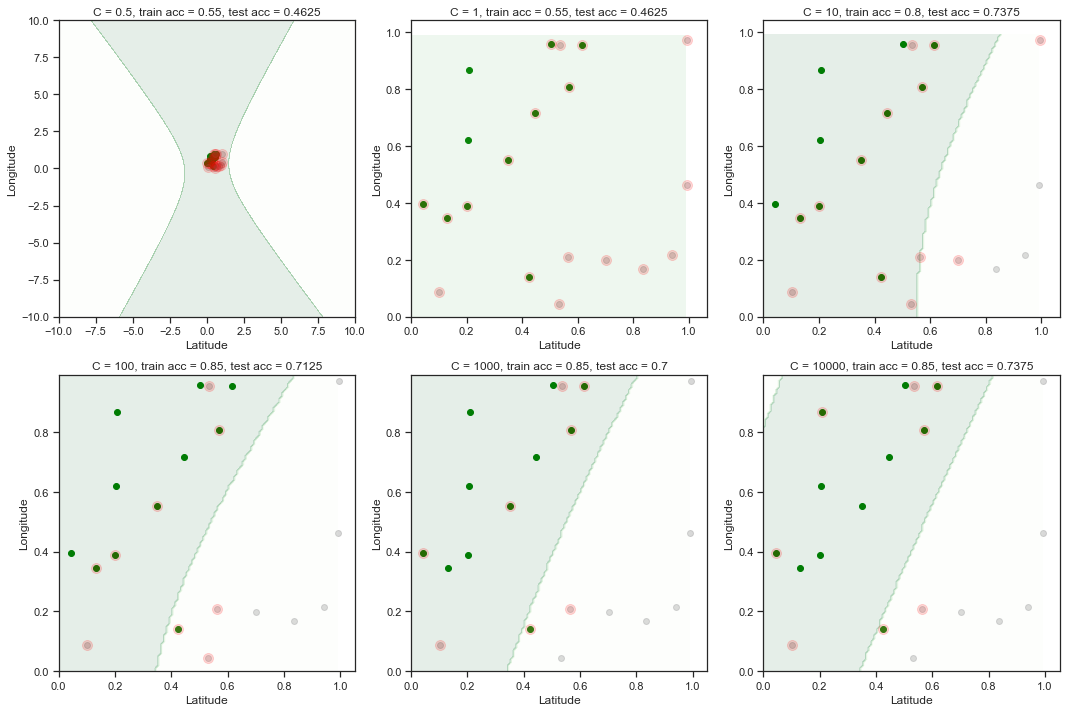

In [12]:
# Fit and plot for different 'C' values when polynomial degree is 2
fig, ax = plt.subplots(2, 3, figsize = (15, 10))

deg = 2

ax[0, 0] = fit_and_plot_svm_for_poly_c(x_train, y_train, x_test, y_test, 0.5, ax[0, 0], (-10, 10), degree = deg)

ax[0, 1] = fit_and_plot_svm_for_poly_c(x_train, y_train, x_test, y_test, 1, ax[0, 1], degree = deg)

ax[0, 2] = fit_and_plot_svm_for_poly_c(x_train, y_train, x_test, y_test, 10, ax[0, 2], degree = deg)

ax[1, 0] = fit_and_plot_svm_for_poly_c(x_train, y_train, x_test, y_test, 100, ax[1, 0], degree = deg)

ax[1, 1] = fit_and_plot_svm_for_poly_c(x_train, y_train, x_test, y_test, 1000, ax[1, 1], degree = deg)

ax[1, 2] = fit_and_plot_svm_for_poly_c(x_train, y_train, x_test, y_test, 10000, ax[1, 2], degree = deg)

plt.tight_layout()

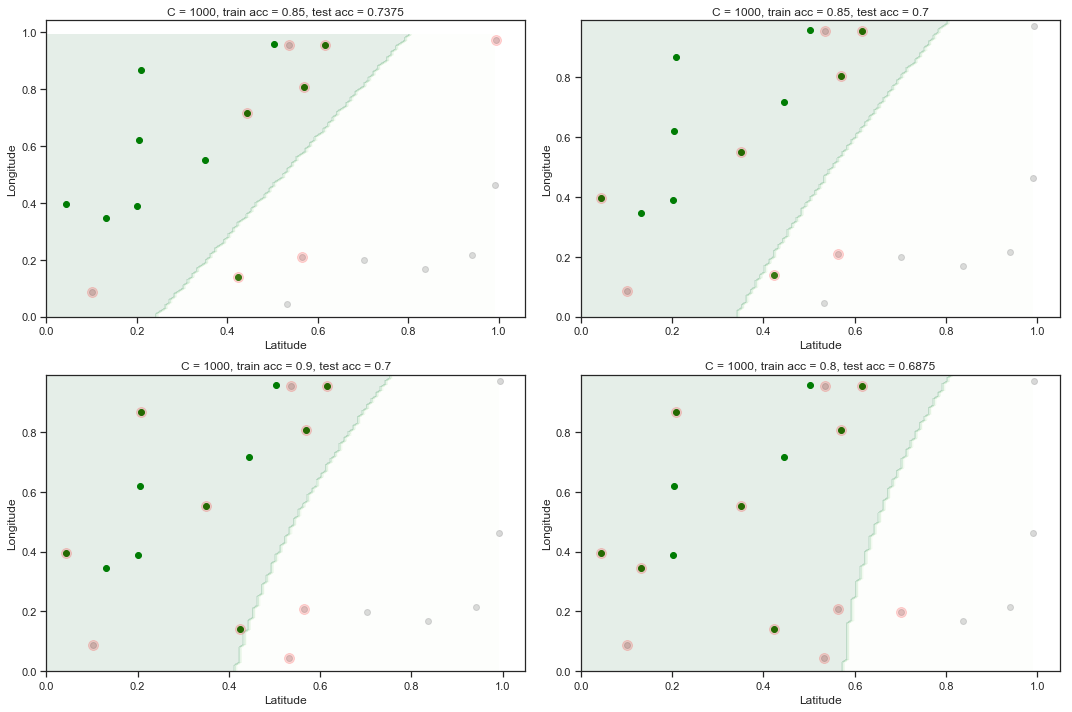

In [13]:
# Fit and plot for different degrees for polynomial boundary...this takes a while
fig, ax = plt.subplots(2, 2, figsize = (15, 10))

ax[0, 0] = fit_and_plot_svm_for_poly_c(x_train, y_train, x_test, y_test, 1000, ax[0, 0], degree = 1)

ax[0, 1] = fit_and_plot_svm_for_poly_c(x_train, y_train, x_test, y_test, 1000, ax[0, 1], degree = 2)

ax[1, 0] = fit_and_plot_svm_for_poly_c(x_train, y_train, x_test, y_test, 1000, ax[1, 0], degree = 3)

ax[1, 1] = fit_and_plot_svm_for_poly_c(x_train, y_train, x_test, y_test, 1000, ax[1, 1], degree = 4)


plt.tight_layout()

In [14]:
# What about other kernels?
def fit_and_plot_svm_for_kernels(x_train, y_train, x_test, y_test, C, ax, bounds=(0, 1), kernel = 'rbf'):
    # Fit SVM model
    model = svm.SVC(C=C, kernel=kernel)
    model.fit(x_train, y_train)
    
    # Train and test error
    tr_acc = model.score(x_train, y_train)
    ts_acc = model.score(x_test, y_test)

    # Plot decision boundary
    plot_decision_boundary(x_train, y_train, model, \
                           'C = ' + str(C)\
                           + ', train acc = ' + str(tr_acc)\
                           + ', test acc = ' + str(ts_acc), ax, bounds)
    
    # Plot support vectors
    sv_indices = model.support_ # retrieve the support vector indices
    ax.scatter(x_train[sv_indices, 0], x_train[sv_indices, 1], color='red', alpha=0.15, s=100) # draw circles around SVs
    
    return ax

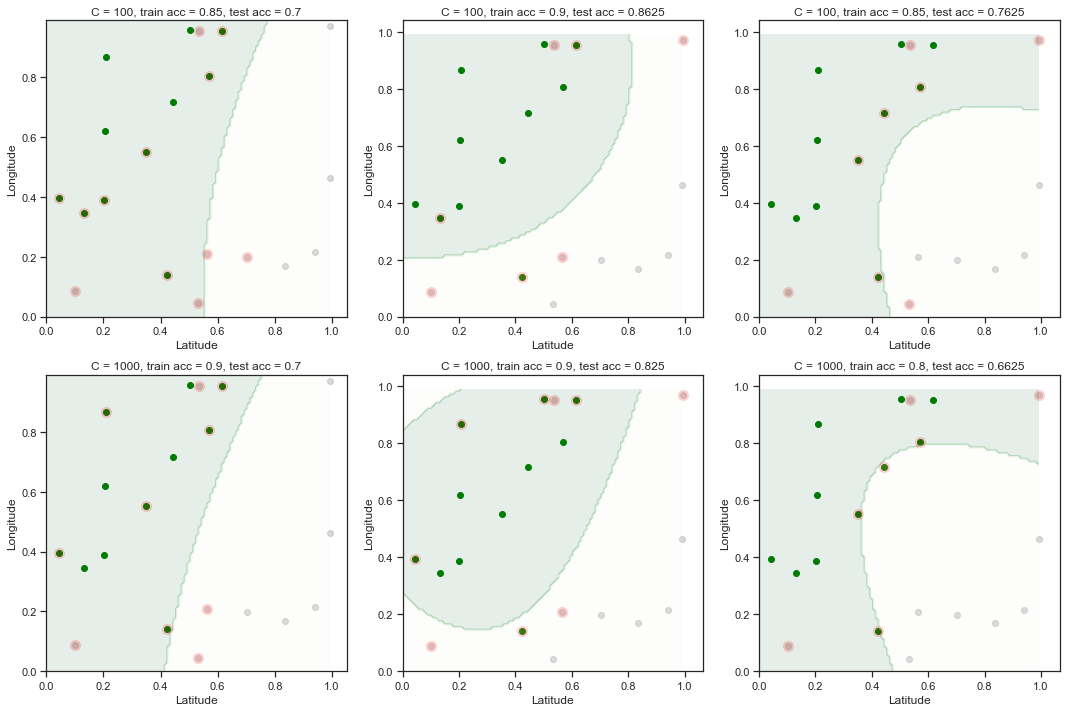

In [15]:
fig, ax = plt.subplots(2, 3, figsize = (15, 10))

ax[0, 0] = fit_and_plot_svm_for_kernels(x_train, y_train, x_test, y_test, 100, ax[0, 0], kernel = "poly")

ax[0, 1] = fit_and_plot_svm_for_kernels(x_train, y_train, x_test, y_test, 100, ax[0, 1], kernel = "rbf")

ax[0, 2] = fit_and_plot_svm_for_kernels(x_train, y_train, x_test, y_test, 100, ax[0, 2], kernel = "sigmoid")

ax[1, 0] = fit_and_plot_svm_for_kernels(x_train, y_train, x_test, y_test, 1000, ax[1, 0], kernel = "poly")

ax[1, 1] = fit_and_plot_svm_for_kernels(x_train, y_train, x_test, y_test, 1000, ax[1, 1], kernel = "rbf")

ax[1, 2] = fit_and_plot_svm_for_kernels(x_train, y_train, x_test, y_test, 1000, ax[1, 2], kernel = "sigmoid")


plt.tight_layout()

In [16]:
# of course, a cross-validation should be used to determine how much penalty 
# (what sklearn calls 'C') should be used for each method